# Create CSV files with FHR from the binary files provided in the FHRMA toolbox

## Use of the FHRMA toolbox and code

## About the CTG files
The FHRMA toolbox provides 66 training files and 90 test files with raw CTG data. They are stored as binary .fhr files. The signals were sampled at 4 Hz and stored in the following format. For each sample:
* A uint32 serves as the UNIX timestamp for the beginning of the recording
* A uint16 corresponds to the FHR from the first sensor (multiplied by 4)
* A uint16 for the FHR signal from the second sensor (multiplied by 4) (unused here)
* A uint8 for the TOCO signal (multiplied by 2)
* A uint8 reserved to store signal quality (unused here).

The FHR signal is set to 0 when it is missing.

## Background information on binary files
Binary files consist of sequential bytes, which are each 8 bits long. Bits are 0s and 1s.

Binary files typically have a header indicating the file type.

A byte can represent a number from 0 to 255, or -127 to +127 if you use one bit to indicate the minus sign. Groups of bytes can be used to represent larger numbers, for example:
| Number of bytes (or bits) | Name | Range (will - this to + this) |
| --- | --- | --- |
| 1 (8 bits) | Byte | 128 |
| 2 (16 bits) | Short | 32,768 |
| 4 (32 bits) | Int | 2,147,483,648 |
| 8 (64 bits) | Int64 | 9,223,372,036,854,775,808 |

## Implementation in MATLAB

The .fhr files can be opened with the `fhropen.m` function in MATLAB and then processed with `preprocess.m` - you can see this implementation in the `.m` files in the `fhrma` folder.

## Implementation in Python

### Set up

Load required packages.

In [1]:
from dataclasses import dataclass
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import io

Define file paths.

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    raw_fhr = './fhrma/train_test_data/raw_fhr/'
    clean_python = './fhrma/train_test_data/clean_fhr_python/'
    clean_matlab = './fhrma/train_test_data/clean_fhr_matlab/'
    expert = './fhrma/expertAnalyses.mat'


paths = Paths()

### Define functions for import and pre-processing

Define function for extracting FHR and saving to csv.

In [3]:
def import_fhr(file_path):
    '''
    Imports .fhr files, extracts the data corresponding to FHR1 and FHR2

    Parameters:
    -----------
    file_path : string
        Location of the .fhr file

    Outputs:
    --------
    fhr1 : array
        FHR signal from the first sensor
    fhr2: array
        FHR signal from the second sensor
    name: string
        Name of the record for these FHR signals
    '''
    # Read file as uint16
    content = np.fromfile(file_path, dtype=np.uint16)

    # Ignore first two bytes, then reshape so you have a 3 x n array
    data = content[2:10000000-1].reshape(-1, 3).T

    # Take first array which corresponds to first sensor
    fhr1 = data[0]/4
    # Take second array which corresponds to second sensor
    fhr2 = data[1]/4

    # Get file name (remove path, change to csv)
    name = file_path.rsplit('/', 1)[1].replace('.fhr', '.csv')

    return(fhr1, fhr2, name)

Define functions used for pre-processing of the FHR signals.

In [4]:
def remove_small_part(fhr):
    '''
    Remove small sections of the signal that are non-physiological or extreme
    values (e.g. FHR too high, too low, or too great a change in a small period
    of time), and remove really short sections of signal surrounded by missing
    signal.

    Parameters
    ----------
    fhr : array
        Fetal heart rate

    Outputs:
    --------
    fhr : array
        Cleaned version of FHR
    '''
    # Remove extreme - set FHR to 0 if it is greater than 220bpm or less than 50bpm
    fhr[np.logical_or(fhr>220, fhr<50)] = 0

    # Find section of FHR that is preceded and followed by zero values - if that
    # section of non-zero values is too short (less than or equal to 5 seconds),
    # set all values in that section to zero

    # Get indices where FHR transitions from zero to non-zero value
    # (e.g. if n has index 396, then 395 was 0 and 396 was not zero)
    n = np.where((fhr[:-1] == 0) & (fhr[1:] > 0))[0] + 1

    # Loop through each of those transition points
    for i in range(len(n)):

        # Get array with all indexes of zero after this point
        zeros = np.where(fhr[n[i]:] == 0)[0]
        # If there were any zeros, get index of the closest (the first)
        if len(zeros) > 0:

            # f is the length of the non-0 section before the next 0
            f = zeros[0]

            # If f is less than 5 seconds (5*4), set that whole section to zero
            if f+1 < 5*4:
                fhr[n[i]:n[i]+f+2] = 0

    # Repeat as above - seperately, as some transition points will have changed
    n = np.where((fhr[:-1] == 0) & (fhr[1:] > 0))[0] + 1
    for i in range(len(n)):
        zeros = np.where(fhr[n[i]:] == 0)[0]
        if len(zeros) > 0:
            f = zeros[0]
            # If f is less than 30 seconds (30*4)
            if f+1 < 30*4:
                # Get array of point before start of zero section before n, and
                # after zero section after f, that are non-zero
                valid_before = np.where(fhr[:n[i]] > 0)[0]
                valid_after = np.where(fhr[n[i]+f:] > 0)[0]
                # As long as there were non-zeros both before and after...
                if (len(valid_before) > 0) and (len(valid_after) > 0):
                    # Get index of last and first non-zero
                    last_valid = valid_before[-1]
                    first_valid = valid_after[0] + n[i] + f
                    # Find difference in FHR between lastvalid and n(i)
                    lastvalid_diff = fhr[n[i]] - fhr[last_valid]
                    # Find difference in FHR between last non-zero in f section, and nextvalid
                    nextvalid_diff = fhr[n[i]+f-1] - fhr[first_valid]
                    # If both of those differences are more than an absolute value of 25bpm,
                    # in the same direction, then set that f section of non-zero all to 0
                    if (lastvalid_diff > 25) and (nextvalid_diff > 25):
                        fhr[n[i]:n[i]+f+2] = 0
                    if (lastvalid_diff < -25) and (nextvalid_diff < -25):
                        fhr[n[i]:n[i]+f+2] = 0

    return (fhr)

In [5]:
def interpol_fhr(fhr):
    '''
    Interpolation of missing signal, to match interpolfhr() in FHRMA

    Parameters
    ----------
    fhr : array
        Fetal heart rate

    Outputs:
    --------
    fhr : array
        Cleaned version of FHR
    '''
    # Get the first index where FHR is non-zero and non-NaN
    n = np.argmax(np.logical_and(fhr>0, np.isfinite(fhr)))

    # Set any values preceding that index to the value of that index
    fhr[:n] = fhr[n]

    # While you have a value of n, and whilst it's not reached the end of the FHR
    while n is not None and n!=-1:

        # Get index of first occurence after n that is zero or NaN
        n = np.argmax(np.logical_or(fhr==0, ~np.isfinite(fhr)))

        # Make boolean array of non-zero or non-NaN after n
        nf_mask = np.logical_and(fhr[n:]>0, np.isfinite(fhr[n:]))

        # If you have found a subsequent value that is non-zero or non-NaN...
        if nf_mask.any() and n!=0:

            # Get the index of the first value that is non-zero and non-NaN
            nf = np.argmax(nf_mask)+n

            # Linear interpolation between nf and the non-zero point before n
            # Round to 3dp to match with MATLAB
            fhr[(n-1):(nf+1)] = np.linspace(fhr[n-1], fhr[nf], nf-n+2)

            # Set n to nf
            n = nf

        # If there were no subsequent values, exit the while loop
        else:
            n=-1

    # Get last index where FHR is non-zero and non-NaN
    n = pd.Series(np.logical_and(fhr>0, np.isfinite(fhr)))[::-1].idxmax()

    # Set any values following that index to the value of that index
    fhr[n:] = fhr[n]

    return (fhr)

In [6]:
def preprocess(fhr1, fhr2, unreliable_signal=[]):
    '''
    Pre-process the FHR1 and FHR2 signals - merging the signals from each
    sensor, removing empty signal at the beginning and end, removing small parts
    of the signal that are not trustable, and linear interpolation of missing
    parts of the signal.

    Parameters:
    -----------
    fhr1 : array
        FHR signal from the first sensor
    fhr2: array
        FHR signal from the second sensor
    unreliable_signal: array
        Sections of unreliable signal, as from ExpertAnalyses.mat

    Outputs:
    --------
    new_sig : array
        Cleaned FHR signal
    '''
    # Find the max value element-wise of the two arrays
    # This should hopefully fill the occurences where FHR=0 (i.e. no signal)
    fhr = np.maximum(fhr1, fhr2)

    # If an unreliable signal is provided, set those sections to 0
    # It is provided in minutes, so multiply by 60*4 (240) to convert back to quarter seconds
    if len(unreliable_signal)>0:
        for i in np.arange(0, len(unreliable_signal)):
            start = round(unreliable_signal[0, 0]*241)-1
            end = round(unreliable_signal[0, 1]*240)
            fhr[start:end] = 0
            print(fhr[start:end])

    # Clean using removesmallpart() - this will remove small sections of the
    # signal that are non-physiological or extreme values (e.g. FHR too high,
    # too low, or too great a change in a small period of time), and remove
    # really short sections of signal surrounded by missing signal.
    fhr = remove_small_part(fhr)

    # Perform linear interpolation
    fhr = interpol_fhr(fhr)

    # If any zero remain, set to NaN
    fhr[fhr==0] = np.nan

    # Round all values to 13dp as in MATLAB
    #fhr = np.around(fhr, 13)

    # Return the cleaned signal
    return (fhr)

In [7]:
def convert_fhr_to_csv(fhr_path, csv_path, expert):
    '''
    Imports all .fhr files in a given directory, extracts the data corresponding
    to FHR1 and FHR2, pre-process and save to csv.

    Parameters:
    -----------
    fhr_path : string
        Location of .fhr files
    csv_path : string
        Location to save the .csv files
    expert : dataframe
        Expert Analysis information which includes unreliable signal identification
    '''
    # Get list of all the .fhr file names in the directory
    files = glob.glob(os.path.join(fhr_path, '*.fhr'))

    # Loop through those files...
    for file_path in files:

        # Import the signals and record name
        fhr1, fhr2, name = import_fhr(file_path)

        # Find the record of any unreliable signal from the expert analysis
        record = name.replace('.csv', '.fhr')
        unreliable_signal = expert.loc[
            expert.filename == record, 'unreliableSignal'].values[0]
        print(record)
        print(unreliable_signal)

        # Pre-process the signals
        fhr = preprocess(fhr1, fhr2, unreliable_signal)

        # Save to csv
        np.savetxt(os.path.join(csv_path, name), fhr, delimiter=',')

### Run functions on an example, to help demonstrate impact of the cleaning process

Import ExpertAnalyses

In [8]:
# Load MAT file and convert to dataframe
expert = io.loadmat(paths.expert)
expert = pd.DataFrame(np.concatenate(expert['data']))
expert.head()

,filename,expertPts,trainingData,baseline,accelerations,decelerations,overshoots,unreliableSignal,notToAnalyse
0,[test01.fhr],"[[], []]",[[0]],[],[],[],[],[],"[[0, 15]]"
1,[test02.fhr],"[[], []]",[[0]],[],[],[],[],[],"[[0, 15]]"
2,[test03.fhr],"[[], []]",[[0]],[],[],[],[],[],"[[0, 15]]"
3,[test04.fhr],"[[], []]",[[0]],[],[],[],[],"[[70.09081150708458, 71.21146414770287], [87.6...","[[0, 15]]"
4,[test05.fhr],"[[], []]",[[0]],[],[],[],[],"[[61.57685702018033, 65.04227405247813], [71.3...","[[0, 15]]"


Import an example file

[130.75 130.75 129.75 129.75 130.75 131.75 131.75 133.25 133.25 131.5 ]
[130.75 130.75 129.75 129.75 130.75 131.75 131.75 133.25 133.25 131.5 ]
test04.csv


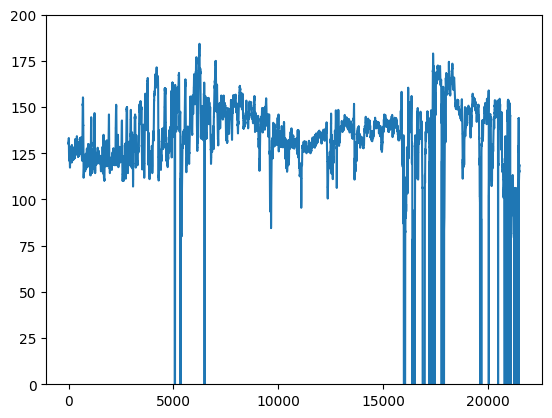

In [9]:
filename = 'test04.fhr'

# Import an example file
file_path = os.path.join(paths.raw_fhr, filename)
fhr1, fhr2, name = import_fhr(file_path)

# Preview data
print(fhr1[:10])
print(fhr2[:10])
print(name)

# Plot one of the data
plt.plot(fhr2)
plt.ylim([0, 200])
plt.show()

Get unreliable signal record from expert analysis, then use to pre-process the raw FHR

[[70.09081151 71.21146415]
 [87.6927866  89.60562473]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

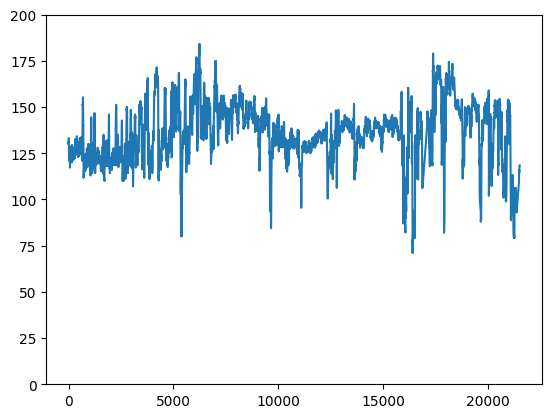

In [10]:
# Get unreliable signal measure from ExpertAnalyses
unreliable_signal = expert.loc[expert.filename == filename, 'unreliableSignal']
if len(unreliable_signal) > 0:
    unreliable_signal = unreliable_signal.values[0]
print(unreliable_signal)

# Pre-process
fhr = preprocess(fhr1, fhr2, unreliable_signal)

# Preview
print(fhr[:10])

# Plot
plt.plot(fhr)
plt.ylim([0, 200])
plt.show()

## Apply functions to the training and test datasets

In [11]:
convert_fhr_to_csv(
    fhr_path = paths.raw_fhr,
    csv_path = paths.clean_python,
    expert = expert
)

test75.fhr
[]
train64.fhr
[]
test40.fhr
[]
test23.fhr
[[ 7.875       8.3       ]
 [22.75       23.225     ]
 [30.00437318 37.76364015]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Compare MATLAB and Python implementation

To validate the implementation in Python, we compare the cleaned signals against those obtained when running the FHRMA package in MATLAB. The csv files compared against were produced using the code in `fhrma/matlab_fhr_preprocess_to_csv.m`. This was based on code from the function `saveMAanalyse.m`. It directly uses functions from the FHRMA package and the raw FHR from the FHRMA package.

Define function for importing all the csv files.

In [12]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict

    Parameters:
    -----------
    directory : string
        Location of csv files
    output_dict : dictionary
        Dictionary to save the FHR arrays to, with key as the record name
        (manually specified in case you would to append to existing dictionary)

    Returns:
    --------
    output_dict : dictionary
        Dictionary of the FHR arrays
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

Import cleaned FHR produced using Python

In [13]:
# Import FHR into dictionary
fhr_python = import_csv(
    directory=paths.clean_python,
    output_dict=dict())

# Convert dictionary to dataframe
fhr_python_df = pd.DataFrame([[key,value] for key,value in fhr_python.items()],
                             columns=['record', 'python'])

Import cleaned FHR produced using MATLAB

In [14]:
# Import FHR into dictionary
fhr_matlab = import_csv(
    directory=paths.clean_matlab,
    output_dict=dict())

# Convert dictionary to dataframe
fhr_matlab_df = pd.DataFrame([[key,value] for key,value in fhr_matlab.items()],
                             columns=['record', 'matlab'])

Combine and compare the FHR from Python and MATLAB

In [15]:
# Merge into a single dataframe
compare_fhr = pd.merge(fhr_python_df, fhr_matlab_df, on='record')

# Preview dataframe
compare_fhr.head()

,record,python,matlab
0,train28,"[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...","[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136..."
1,test80,"[125.25, 125.25, 125.75, 125.75, 125.25, 125.2...","[125.25, 125.25, 125.75, 125.75, 125.25, 125.2..."
2,test68,"[118.25, 118.5, 118.5, 118.5, 118.5, 118.75, 1...","[118.25, 118.5, 118.5, 118.5, 118.5, 118.75, 1..."
3,train04,"[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...","[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130..."
4,train31,"[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...","[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ..."


In [16]:
# Loop through each record, comparing the python and FHRMA results
for index, row in compare_fhr.iterrows():

    # Extract the two arrays
    res_python = row['python']
    res_matlab = row['matlab']

    # Save number of matches, total possible matches, and every element matches
    compare_fhr.loc[compare_fhr.index[index], 'n_match'] = (res_python==res_matlab).sum()
    compare_fhr.loc[compare_fhr.index[index], 'total_possible'] = len(res_python)
    compare_fhr.loc[compare_fhr.index[index], 'all_match'] = (res_python==res_matlab).all()

    # Find element wise differences
    diff = res_python - res_matlab
    compare_fhr.loc[compare_fhr.index[index], 'sum_abs_diff'] = abs(diff).sum()

# Add column with rounded sum_abs_diff
compare_fhr['sum_abs_diff_round5dp'] = round(compare_fhr['sum_abs_diff'], 5)

# Add column showing number of non-matching elements
compare_fhr['n_different'] = compare_fhr['total_possible'] - compare_fhr['n_match']

# Preview dataframe with the newly added columns
compare_fhr.head()

/tmp/ipykernel_32951/2148730012.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  compare_fhr.loc[compare_fhr.index[index], 'all_match'] = (res_python==res_matlab).all()


,record,python,matlab,n_match,total_possible,all_match,sum_abs_diff,sum_abs_diff_round5dp,n_different
0,train28,"[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...","[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...",17595.0,17595.0,True,0.000000e+00,0.00000,0.0
1,test80,"[125.25, 125.25, 125.75, 125.75, 125.25, 125.2...","[125.25, 125.25, 125.75, 125.75, 125.25, 125.2...",23879.0,24253.0,False,1.014087e-10,0.00000,374.0
2,test68,"[118.25, 118.5, 118.5, 118.5, 118.5, 118.75, 1...","[118.25, 118.5, 118.5, 118.5, 118.5, 118.75, 1...",23829.0,25274.0,False,9.029112e+02,902.91122,1445.0
3,train04,"[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...","[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...",17595.0,17595.0,True,0.000000e+00,0.00000,0.0
4,train31,"[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...","[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...",11631.0,11631.0,True,0.000000e+00,0.00000,0.0


In [17]:
# See how many match
display(compare_fhr['all_match'].value_counts())

all_match
False    125
True      31
Name: count, dtype: int64

In [18]:
# See the false entries
display(compare_fhr[compare_fhr['all_match'] == False])

,record,python,matlab,n_match,total_possible,all_match,sum_abs_diff,sum_abs_diff_round5dp,n_different
1,test80,"[125.25, 125.25, 125.75, 125.75, 125.25, 125.2...","[125.25, 125.25, 125.75, 125.75, 125.25, 125.2...",23879.0,24253.0,False,1.014087e-10,0.00000,374.0
2,test68,"[118.25, 118.5, 118.5, 118.5, 118.5, 118.75, 1...","[118.25, 118.5, 118.5, 118.5, 118.5, 118.75, 1...",23829.0,25274.0,False,9.029112e+02,902.91122,1445.0
5,train13,"[210.0, 210.0, 210.0, 210.0, 210.0, 210.0, 210...","[210.0, 210.0, 210.0, 210.0, 210.0, 210.0, 210...",29196.0,29226.0,False,7.773338e-12,0.00000,30.0
6,train47,"[153.5, 153.0, 153.5, 153.5, 153.5, 153.5, 152...","[153.5, 153.0, 153.5, 153.5, 153.5, 153.5, 152...",25941.0,28022.0,False,2.623860e+03,2623.85984,2081.0
7,test70,"[143.25, 143.25, 143.25, 143.0, 142.5, 142.5, ...","[143.25, 143.25, 143.25, 143.0, 142.5, 142.5, ...",25519.0,25925.0,False,1.197265e-10,0.00000,406.0
...,...,...,...,...,...,...,...,...,...
150,test04,"[130.75, 130.75, 129.75, 129.75, 130.75, 131.7...","[130.75, 130.75, 129.75, 129.75, 130.75, 131.7...",20494.0,21517.0,False,1.738668e+04,17386.67609,1023.0
151,test76,"[144.5, 144.0, 143.0, 143.0, 143.5, 143.5, 143...","[144.5, 144.0, 143.0, 143.0, 143.5, 143.5, 143...",27595.0,29507.0,False,2.320100e+03,2320.09962,1912.0
152,test22,"[124.0, 124.0, 124.0, 124.0, 124.0, 122.25, 12...","[124.0, 124.0, 124.0, 124.0, 124.0, 122.25, 12...",26934.0,27607.0,False,5.819329e+02,581.93294,673.0
154,train52,"[134.75, 135.0, 135.0, 135.75, 136.5, 136.5, 1...","[134.75, 135.0, 135.0, 135.75, 136.5, 136.5, 1...",40801.0,42446.0,False,4.094858e-10,0.00000,1645.0


### Look at an example

In [19]:
train62_python = fhr_python_df.loc[fhr_python_df['record']=='train62', 'python'].values[0]
train62_matlab = fhr_matlab_df.loc[fhr_matlab_df['record']=='train62', 'matlab'].values[0]

In [20]:
print(len(train62_python))
print(len(train62_matlab))

43767
43767


In [21]:
train62_python[37391:37954]

array([166.5       , 166.5       , 169.5       , 170.        ,
       171.        , 171.        , 172.25      , 172.        ,
       172.        , 172.        , 172.        , 172.        ,
       172.        , 172.        , 172.        , 172.        ,
       172.        , 172.        , 172.        , 172.        ,
       172.        , 172.        , 172.        , 171.27302632,
       170.54605263, 169.81907895, 169.09210526, 168.36513158,
       167.63815789, 166.91118421, 166.18421053, 165.45723684,
       164.73026316, 164.00328947, 163.27631579, 162.54934211,
       161.82236842, 161.09539474, 160.36842105, 159.64144737,
       158.91447368, 158.1875    , 157.46052632, 156.73355263,
       156.00657895, 155.27960526, 154.55263158, 153.82565789,
       153.09868421, 152.37171053, 151.64473684, 150.91776316,
       150.19078947, 149.46381579, 148.73684211, 148.00986842,
       147.28289474, 146.55592105, 145.82894737, 145.10197368,
       144.375     , 143.64802632, 142.92105263, 142.19

In [22]:
train62_matlab[37391:37954]

array([167.48714539, 167.47429078, 167.46143617, 167.44858156,
       167.43572695, 167.42287234, 167.41001773, 167.39716312,
       167.38430851, 167.3714539 , 167.35859929, 167.34574468,
       167.33289007, 167.32003546, 167.30718085, 167.29432624,
       167.28147163, 167.26861702, 167.25576241, 167.2429078 ,
       167.23005319, 167.21719858, 167.20434397, 167.19148936,
       167.17863475, 167.16578014, 167.15292553, 167.14007092,
       167.12721631, 167.1143617 , 167.10150709, 167.08865248,
       167.07579787, 167.06294326, 167.05008865, 167.03723404,
       167.02437943, 167.01152482, 166.99867021, 166.9858156 ,
       166.97296099, 166.96010638, 166.94725177, 166.93439716,
       166.92154255, 166.90868794, 166.89583333, 166.88297872,
       166.87012411, 166.8572695 , 166.84441489, 166.83156028,
       166.81870567, 166.80585106, 166.79299645, 166.78014184,
       166.76728723, 166.75443262, 166.74157801, 166.7287234 ,
       166.71586879, 166.70301418, 166.69015957, 166.67